In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import math

**Task 1.**
1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. На
основе генератора схемы Бернулли построить датчик биномиального распределения.
2. Реализовать генератор геометрического распределения; проверить для данного
распределения свойство отсутствия памяти.
3. Промоделировать игру в орлянку: бесконечную последовательность независимых испытаний Бернулли с бросанием “правильной” (честной, $p$ = 0.5) монеты.
Величина “выигрыша” $S_n$ определяется как сумма по $n$ испытаниям значений 1
и −1 в зависимости от выпавшей стороны монеты. Проиллюстрировать в виде
ломаной поведение нормированной суммы $Y (i) = \frac{S_i}{\sqrt{i}}$
как функцию от номера
испытания i для отдельно взятой траектории. Дать теоретическую оценку для
значения $Y (n)$ при $n → ∞$


In [5]:
#Part 1

def bern_gen(p, sizes=1):
    if (type(p) != float) and (p < 0 or p > 1):
        raise ValueError('p must be in [0, 1]')
    if type(sizes) == int:
        if sizes <= 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return (np.random.uniform(low=0, high=1, size=sizes) <= p).astype(int)
    elif type(sizes) == tuple:
        if len(sizes) == 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        for i in sizes:
            if type(i) != int or i <= 0:
                raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return (np.random.uniform(low=0, high=1, size=sizes) <= p).astype(int)

def bin_gen(n, p, sizes):
    if type(n) != int or n <= 0:
        raise ValueError('n must be natural number')
    if type(sizes) == tuple:
        new_sizes = (n, *sizes)
    elif type(sizes) == int:
        new_sizes = (n, sizes)
    else:
        raise TypeError('sizes must be positive integer or a tuple of positive integers')
    S = bern_gen(p, new_sizes)
    return np.sum(S, axis = 0)


In [6]:
#test
print(bern_gen(0.1, 10))
print(bin_gen(10, 0.3, (3,4)))



[0 0 0 1 1 1 0 0 0 0]
[[1 3 2 4]
 [3 5 0 4]
 [1 1 2 2]]


**Part 2**

Пусть $\xi ∼ exp(k), k > 0.$ Тогда $\lfloor \xi \rfloor \sim Geom(p), p = 1 - e^{-k}, k = -\ln(1-p)$. Функция распределения $\xi$ равна $F(x) = (1 - e^{-kx})\mathbb{I}(x≥0).$ Тогда $(⌊ \xi \rfloor = n) ⇔ (n \leq \xi < n+1).$ $F(n+1) - F(n) = e^{-kn}(1-e^{-k}) = (1-p)^np.$ Тогда нужно сгенерировать случайную величину, имеющую экспоненциальное распределение. $F_{\xi}^{-1}(y) = -\dfrac{1}{k} \ln(1-y).$ Так как $F_{\xi}(y)$ непрерывна и строго возрастает, то $\xi \sim F^{-1}_{\xi}(U), U \sim U(0,1).$
$1-U$ имеет равномерное распределение на отрезке [0,1]. Таким образом, формула для генерации геометрического распределения:

$X = \dfrac{\ln(U)}{\ln(1-p)}.$


In [8]:
#Part 2
def geom_gen(p, sizes):
    if (type(p) != float) or not (0 < p <= 1):
        raise ValueError('p must be positive')
    if type(sizes) == int:
        if sizes <= 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return np.log(np.random.uniform(low=0, high=1, size=sizes)) / (np.log(1-p))
    elif type(sizes) == tuple:
        if len(sizes) == 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        for i in sizes:
            if type(i) != int or i <= 0:
                raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return np.log(np.random.uniform(low=0, high=1, size=sizes)) / (np.log(1-p))

#check memoryless

def memoryless_prop(sample, shift):
    shifted_sample = sample[sample > shift] - shift

    bins = np.arange(1, np.max(sample) + 1.5) - 0.5

    plt.figure(figsize=(12, 6))

    plt.hist(sample, bins=bins, alpha=0.5, color='blue', density=True, label='Оригинальная выборка')
    plt.hist(shifted_sample, bins=bins, alpha=0.4, color='black', density=True, label=f'Сдвинутая на {k} выборка')
    plt.title('Свойство отсутствия памяти у геометрического распределения')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.grid()
    plt.xlim(0, np.percentile(sample, 99.9))
    plt.show()


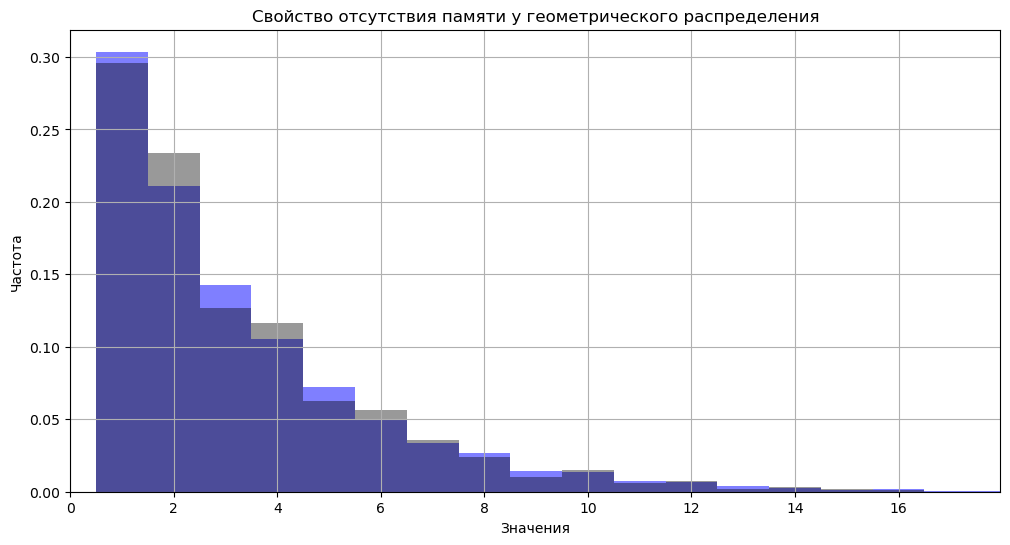

In [9]:
p = 0.3
n = 10000
k = 6
x = geom_gen(p, n)
memoryless_prop(x, k)

Part 3.
Теоретическая оценка:
Имеем последовательность независимых случайных величин $\xi_k, k \in \mathbb{N}$, имеющих модифицированное (т.е. вместо точки 0 ненулевую вероятность имеет точка -1) распределение Бернулли с параметром $p = 0.5.$ Математическое ожидание $\mathbb{E}\xi_k = 0,$ дисперсия $\mathbb{D}\xi_k = 1.$ $S_n = \sum\limits_{k=1}^n\xi_k,$ математическое ожидание суммы равно 0, дисперсия равна сумме дисперсий (в силу независимости случайных величин) и равна $n.$ Тогда по центральной предельной теореме $\mathbb{P}(\dfrac{S_n}{\sqrt{n}} < x) \xrightarrow{d} \mathcal{N}(0, 1), \quad n → ∞.$  

In [820]:
#Part 3
def heads_or_tails_game(n):
    bern_sample = bern_gen(0.5, n)
    wins_seq = np.where(bern_sample == 1, 1, -1)
    sums = np.cumsum(wins_seq)
    Y = sums / np.sqrt(np.arange(1, n + 1))
    plt.figure(figsize=(12,6))
    plt.plot(Y, label='Y(k) = S_k/sqrt(k)$')
    plt.xlabel('Номер испытания')
    plt.ylabel('Y(k)')
    plt.title('Нормированные суммы Y(k)')
    plt.grid()
    plt.legend()
    plt.show()

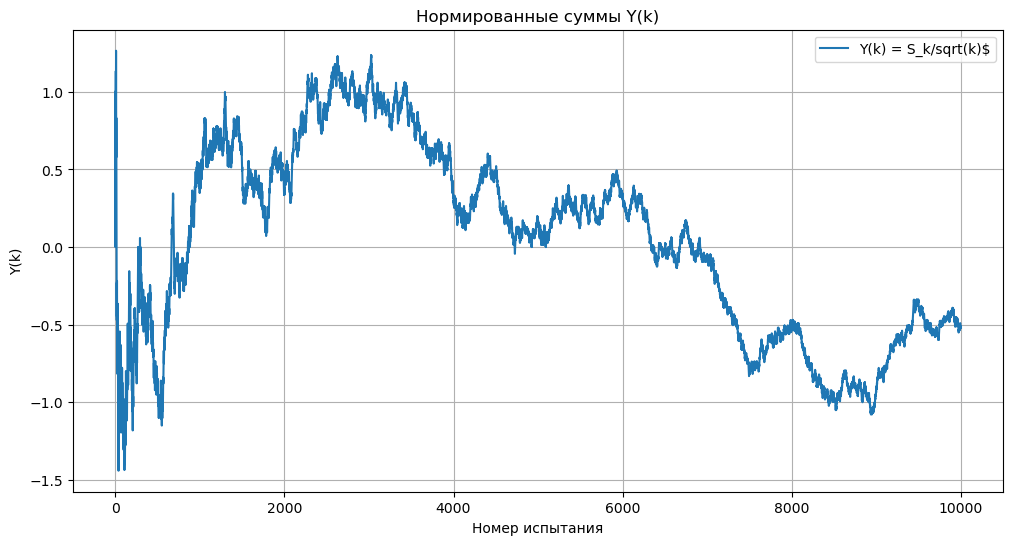

In [822]:
n = 10000
heads_or_tails_game(n)

**Задание 2.**
1. Построить датчик сингулярного распределения, имеющий в качестве функции
распределения канторову лестницу. С помощью критерия Колмогорова убедиться в корректности работы датчика.
2. Для канторовых случайных величин с помощью критерия Смирнова проверить
свойство симметричности относительно $\dfrac{1}{2}$
($X$ и $1 - X$ распределены одинаково)
и свойство самоподобия относительно деления на 3 (условное распределение $Y$
при условии $Y ∈ [0, 1/3]$ совпадает с распределением $\dfrac{Y}{3}$
).
3. Рассчитать значения математического ожидания и дисперсии для данного распределения. Сравнить теоретические значения с эмпирическими (для различных объемов выборок), проиллюстрировать сходимость эмпирических значений
к теоретическим.

Сингулярное распределение, имеющее в качестве функции распределения канторову лестницу, можно моделировать через разложение числа в троичной системе счисления. В канторово множество попадают все числа, не имеющие единиц в троичной записи ⇒ имеем модифицированное распределение Бернулли(имеет ненулевую вероятность в точках 0 и 2) с $p = 0.5.$ Генерировать бесконечную последовательность мы не можем, поэтому необходимо ввести погрешность вычислений $\varepsilon.$ Хотим, чтобы хвост ряда $\sum\limits_{n=1}^{\infty} \dfrac{2 \xi_n}{3^n}$ был меньше этой погрешности, т.е. $\sum\limits_{n=N+1}^{\infty} \dfrac{2 \xi_n}{3^n} \leq \sum\limits_{n=N+1}^{\infty} \dfrac{2}{3^n} = \dfrac{\frac{2}{3^{N+1}}}{1-\frac{1}{3}} = \dfrac{1}{3^N} \leq \varepsilon,$ откуда $N \geq \log_3(\dfrac{1}{\varepsilon}).$

Тогда значение случайной величины равно $x = \sum\limits_{n=1}^{N(\varepsilon)} \dfrac{2 \xi_n}{3^n},$ а функция распределения в этой точке равна $F(x) = \sum\limits_{n=1}^{N(\varepsilon)} \dfrac{\xi_n}{2^n}.$

In [15]:
#Part 1
def singular_gen(n, eps):
    N = int(np.ceil(np.log(1/eps) / np.log(3)))
    bern_samples = bern_gen(0.5, (n, N))
    powers_of_three = 3.0 ** (-np.arange(1, N + 1))
    powers_of_two = 2.0 ** (-np.arange(1, N + 1))
    x = 2 * bern_samples @ powers_of_three.T
    f_x = bern_samples @ powers_of_two.T
    return x, f_x

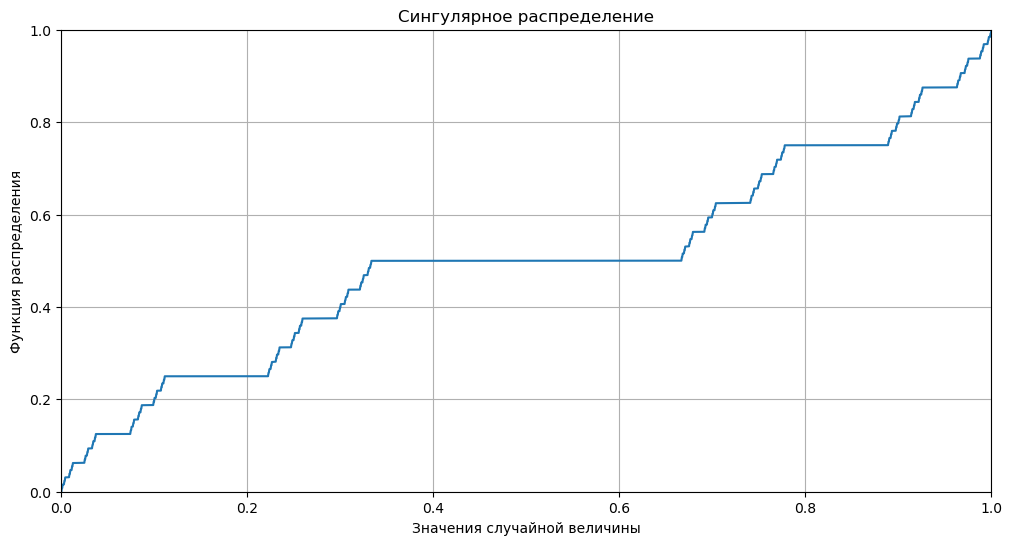

In [16]:
n = 10000
eps = 1e-6
x, f_x = singular_gen(n, eps)
x = np.sort(x)
f_x = np.sort(f_x)
plt.figure(figsize=(12,6))
plt.xlabel('Значения случайной величины')
plt.ylabel('Функция распределения')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(x, f_x)
plt.grid()
plt.title('Сингулярное распределение')
plt.show()


**Критерий Колмогорова**

Статистика критерия $D_n = \sup\limits_{x\in \mathbb{R}} |F_n(x) - F_0(x)|,$ где $F_n(x)$ ~---~ выборочная функция распределения, $F_0(x)$ ~---~ канторова лестница. Для вычисления $p$-value используется функция Колмогорова $F_k(x) = 1 + 2\sum\limits_{k=1}^{\infty}(-1)^ke^{-2k^2x}.$ Тогда $p = 1 - F_k(\sqrt{n}D_n).$ Если $p > \alpha,$ то гипотеза $H_0: F_{\xi}(x) = F_0(x)$ принимается, иначе ~---~ отвергается(здесь $\alpha$ ~--~ заданный уровень значимости).

In [18]:
def Kolmogorov_criterion(x, f_x, alpha):
    x = np.sort(x)
    f_x = np.sort(f_x)
    emp_x = np.arange(1, x.shape[0] + 1) / x.shape[0]
    D_n = max(abs(f_x - emp_x))
    k_values = np.arange(1, x.shape[0] + 1)
    series_terms = lambda y: (-1) ** k_values * np.exp(-2 * (k_values ** 2) * (y ** 2))
    F_k = 1 + 2 * np.sum(series_terms(np.sqrt(k_values[-1]) * D_n))
    p = 1 - F_k
    p = max(0, min(1,p))
    return p > alpha

In [19]:
n = 10000
eps = 1e-6
x, f_x = singular_gen(n, eps)

alpha = 0.05
Kolmogorov_criterion(x, f_x, alpha)

True

**Part 2**
Теорема Смирнова:
Рассмотрим $X = (X_1, X_2, \dots, X_n), Y = (Y_1, Y_2, \dots, Y_m)$ ~--~ выборки, элементы которых имеют распределения $F$ и $G$ соответственно, $F_n$ и $G_m$ ~---~ построенные по ним эмпирические функции распределения. Рассматривается следующая статистика: $D_{nm} = \sup\limits_{x \ in \mathbb{R}} |F_n(x) - G_m(x)|.$ Далее аналогично критерию Колмогорова рассматриваем значение функции Колмогорова в точке $D_{nm}$ и соответствующее ему $p-value.$ Если $p > \alpha,$ то гипотеза $H_0: F(x) = G(x)$ принимается, иначе ~---~ отвергается(здесь $\alpha$ ~--~ заданный уровень значимости).

In [21]:
def Smirnov_criterion(x, y, alpha):
    points = np.concatenate([x, y])
    points = np.unique(points)
    points = np.sort(points)
    n = np.size(x)
    m = np.size(y)
    def emp_in_x(x, point, n):
        return np.size(x[x <= point]) / n
    emp_x_vectorized = np.vectorize(lambda point: emp_in_x(x, point, n))
    emp_y_vectorized = np.vectorize(lambda point: emp_in_x(y, point, m))
    emp_x = emp_x_vectorized(points)
    emp_y = emp_y_vectorized(points)
    
    D_nm = max(abs(emp_y - emp_x))
    k_values = np.arange(1, x.shape[0] + 1)
    series_terms = lambda y: (-1) ** k_values * np.exp(-2 * (k_values ** 2) * (y ** 2))
    F_k = 1 + 2 * np.sum(series_terms(np.sqrt(n * m / (n + m)) * D_nm))
    p = 1 - F_k
    p = max(0, min(1,p))
    return p > alpha


    

In [22]:
n = 10000
m = 5000
eps = 1e-6
alpha = 0.05
x, _ = singular_gen(n, eps)
y, _ = singular_gen(m, eps)
y = 1 - y
Smirnov_criterion(x, y, alpha)

True

In [23]:
n = 10000
eps = 1e-6
alpha = 0.05
x, _ = singular_gen(n, eps)
y = x[x <= 1 / 3]
Smirnov_criterion(x / 3, y, alpha)

True

Part 3.

Теоретические оценки:
математическое ожидание $\mathbb{E}X = \dfrac{1}{2},$ дисперсия $\mathbb{D}X = \dfrac{1}{8}.$ 


In [25]:
def expectation_var_emp(n, eps):
    x, _ = singular_gen(n, eps)
    expectation = np.sum(x) / np.size(x)
    var = np.sum((x - expectation) ** 2) / np.size(x)
    return expectation, var
    

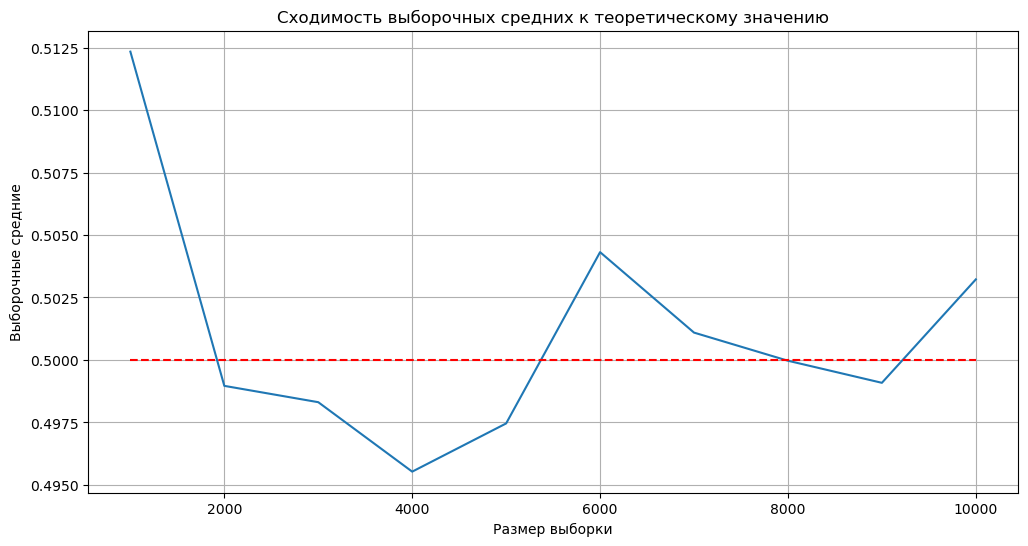

In [26]:
eps = 1e-6
n = np.arange(1000, 10001, 1000)
expectations = []
vars = []
for i in n:
    expectation, var = expectation_var_emp(int(i), eps)
    expectations.append(expectation)
    vars.append(var)
plt.figure(figsize=(12, 6))
plt.plot(n, expectations)
plt.xlabel('Размер выборки')
plt.ylabel('Выборочные средние')
plt.plot(n, 1/2 * np.ones(n.shape), 'r--')
plt.title('Сходимость выборочных средних к теоретическому значению')
plt.grid()
plt.show()

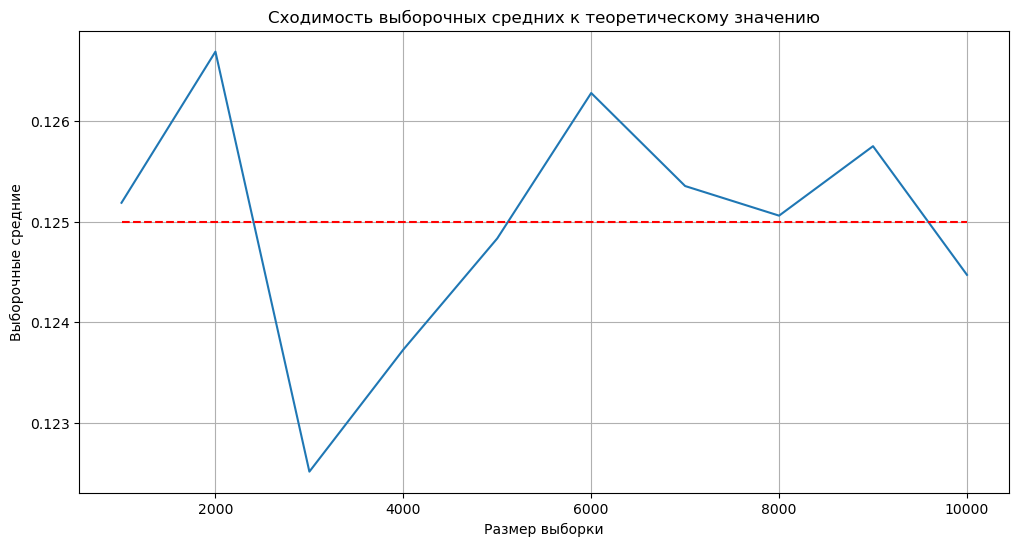

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(n, vars)
plt.xlabel('Размер выборки')
plt.ylabel('Выборочные средние')
plt.plot(n, 1/8 * np.ones(n.shape), 'r--')
plt.title('Сходимость выборочных средних к теоретическому значению')
plt.grid()
plt.show()

**Задание 3**

1. Построить датчик экспоненциального распределения. Проверить для данного
распределения свойство остутствия памяти.
2. Пусть $X_1,\dots, X_n$ — независимые экспоненциально распределенные случайные
величины с параметрами $λ_1,\dots, λ_n$. Найти распределение случайной величины
$Y = \min(X_1,\dots, X_n)$.
3. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.
4. Построить датчик пуассоновского распределения как предел биномиального распределения. Убедиться в корректности построенного датчика при помощи критерия $χ^2$Пирсона.
5. Построить датчик стандартного нормального распределения методом моделирования случайных величин парами с переходом в полярные координаты (преобразование Бокса-Мюллера). Проверить при помощи $t$-критерия Стьюдента равенство математических ожиданий, а при помощи критерия Фишера — равенство
дисперсий.


Part 1.
Датчик фактически уже был построен в задании 1.

In [30]:
def exp_gen(k, sizes):
    #-ln(1-U) / k
    if ((isinstance(k, float) == False) and (isinstance(k, int) == False)) or not (k > 0):
        raise ValueError('k must be positive')
    if type(sizes) == int:
        if sizes <= 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return np.log(np.random.uniform(low=0, high=1, size=sizes)) / (np.log(1-p))
    elif type(sizes) == tuple:
        if len(sizes) == 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        for i in sizes:
            if type(i) != int or i <= 0:
                raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return -np.log(1 - np.random.uniform(low=0, high=1, size=sizes)) / k
    

In [31]:
k = 1.6
sizes = (1,3,5)
exp_gen(k, sizes)

array([[[0.26207804, 0.93631066, 0.46678261, 0.40034324, 0.03314401],
        [0.02368879, 0.15901676, 0.71391039, 0.65272204, 0.2707351 ],
        [1.6844366 , 0.50127651, 0.92175479, 0.44328857, 1.67611038]]])

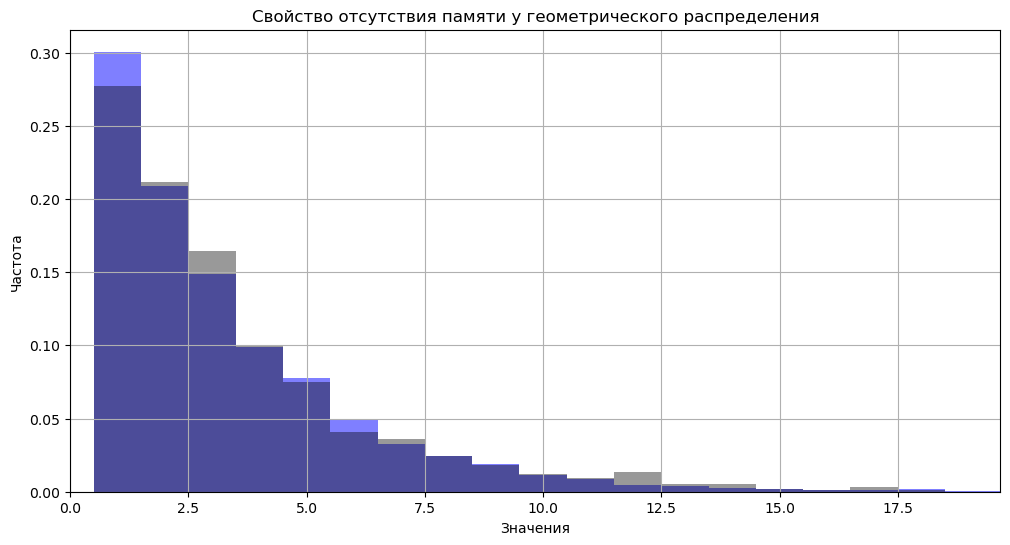

In [32]:
k = 1.6
sizes = 10000
x = exp_gen(k, sizes)
shift = 6
memoryless_prop(x, shift)



Part 2.
$X_k \sim exp(\lambda_k)$
$$
\mathbb{P}(\min\{X_1, X_2,\dots, X_n\} < x) = 1 - \mathbb{P}(X_1 \geq x, X_2 \geq x, \dots, X_n \geq x) = 1 - \prod\limits_{k=1}^n\mathbb{P}(X_k \geq x) = 1 - \prod\limits_{k=1}^n e^{-\lambda_k x} = 1 - e^{-x\sum\limits_{k=1}^n \lambda_k}
$$
Таким образом, $\min\{X_1, X_2, \dots, X_n\} \sim exp(\sum\limits_{k=1}^n \lambda_k)$

Part 3.
Пусть $\xi_1, \xi_2, \dots, \xi_n$ ~--~ независимые случайные величины, имеющие экспоненциальное распределение с параметром $\lambda$. Пусть $X = \max\{n: \sum\limits_{k=1}{n} \leq 1\}.$ Тогда $X - 1$ имеет пуассоновское распределение с параметром $\lambda$

In [35]:
def pois_one(L):
    X = 0
    summ = 0
    while summ <= 1:
        summ += exp_gen(L, 1)
        X += 1
    return X - 1

In [36]:
def pois_gen(L, sizes):
    vec_pois = np.vectorize(pois_one)
    if ((isinstance(L, float) == False) and (isinstance(L, int) == False)) or not (L > 0):
        raise ValueError('L must be positive') 
    if type(sizes) == int:
        if sizes <= 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return vec_pois(np.ones(sizes) * L)
    elif type(sizes) == tuple:
        if len(sizes) == 0:
            raise ValueError('sizes must be positive integer or a tuple of positive integers')
        for i in sizes:
            if type(i) != int or i <= 0:
                raise ValueError('sizes must be positive integer or a tuple of positive integers')
        return vec_pois(np.ones(sizes) * L)

In [37]:
L = 1.0
sizes = 10
pois_gen(L, sizes)

array([0, 1, 0, 0, 0, 0, 3, 0, 0, 0])

Part 4.
Пусть $\xi_n$ имеет биномиальное распределение с параметрами $n$ и $p$. Пусть $n \rightarrow +\infty, p_n \rightarrow 0, np_n \rightarrow \lambda.$ Тогда по теореме Пуассона $\mathbb{P}(\xi_n = k) \rightarrow \dfrac{e^{-\lambda}\lambda^k}{k!}.$

In [39]:
def pois_lim_bin(L, n, sizes):
    if ((isinstance(L, float) == False) and (isinstance(L, int) == False)) or not (L > 0):
        raise ValueError('L must be positive')
    p = L / n
    return bin_gen(n, p, sizes)

In [81]:
n = 10 ** 6
L = 2
sizes = 100
x = pois_lim_bin(L, n, sizes)
print(x)

[1 1 2 5 1 0 0 1 2 2 0 1 4 1 1 4 3 2 3 4 1 3 0 3 0 2 3 3 2 0 0 2 2 4 3 4 2
 0 2 6 1 4 3 3 2 3 1 2 2 4 1 3 3 1 3 1 3 3 0 2 1 3 2 2 2 1 8 1 4 1 3 0 1 1
 1 5 4 5 3 3 4 4 1 4 2 2 2 1 3 4 1 2 2 3 2 2 2 4 1 2]


Критерий $\chi^2$ Пирсона. Считаем частоты $n_k$ по выборке как количество величин, равных $k$, теоретические частоты равны $n_k^{\omega} = n\dfrac{e^{-\lambda}\lambda^k}{k!}.$ Статистика $\chi^2 = \sum\limits_{k \in \{a_1, a_2, \dots, a_m\}} \dfrac{(n_k^{\omega} - n_k)^2}{n_k^{\omega}},$ где $a_1, a_2,  \dots, a_m$ ~---~ уникальные значения в выборке. $p-value$ равно $p = 1 - F_{\chi^2}(\chi^2, \nu),$ где $F_{\chi^2}$ ~---~ функция распределения $\chi^2,$ $\nu = m - 1$ ~---~ число степеней свободы. Уровень значимости возьмем равным $\alpha = 0.05.$

In [87]:
def chi_square(sample, L, alpha):
    unique_vals, counts = np.unique(sample, return_counts=True)
    n = np.size(sample)
    observed_freq = counts / n
    exp_freq = n * np.exp(-L) * (L ** unique_vals) / np.vectorize(math.factorial)(unique_vals)
    numerator = (exp_freq - observed_freq) ** 2
    chi_sq = np.sum(numerator / exp_freq)
    p_value = 1 - stats.chi2.cdf(chi_sq, df=len(unique_vals) - 1)
    return p_value > alpha

In [89]:
alpha = 0.05
chi_square(x, L, alpha)

False

Part 5.

Рассмотрим $(X_1, X_2)$ ~--~ случайный вектор, компоненты которого имеют стандартное нормальное распределение. Найдем распределение полярных координат.
В силу симметрии угол $\varphi$ имеет равномерное распределение на отрезке $[0, 2\pi].$ Квадрат радиуса $r^2 = X_1^2 + X_2^2$ по определению имеет распределение $\chi^2$ с двумя степенями свободы, которое совпадает с экспоненциальным с параметром $\dfrac{1}{2}.$ Тогда $X_1 = r\cos(\varphi) \sim \mathbb{N}(0, 1), X_2 = r\sin(\varphi) \sim \mathbb{N}(0, 1).$

In [95]:
def Gauss_B_M_gen(size):
    r = exp_gen(1 / 2, size // 2)
    phi = np.random.uniform(low=0, high=1, size = size // 2) * 2 * np.pi
    return np.concatenate([np.sqrt(r) * np.cos(phi),np.sqrt(r) * np.sin(phi)])

Критерий Стьюдента. Рассматривается выборка $X_1, X_2, \dots, X_n$ из нормального распределения с неизвестными параметрами. Гипотеза $H_0: \mathbb{E}X = \mu.$ Оценка стандартного отклонения $\sigma' = \sqrt{\dfrac{1}{n - 1}\sum\limits_i (X_i - \overline{X})^2}.$ Тогда статистика $U = \sqrt{n} \dfrac{\overline{X} - \mu}{\sigma'}$ имеет распределение Стьюдента с $n - 1$ степенью свободы при условии истинности $H_0.$ Нулевая гипотеза принимается, если $|t| < q,$ где $q$ ~--~ квантиль распределения Стьюдента с $n-1$ степенью свободы порядка $1 -\dfrac{\alpha}{2}.$ 

In [98]:
def t_student_criterion(sample, alpha):
    n = len(sample)
    q = scipy.stats.t.ppf(1 - alpha/2, df=n - 1)
    m = np.mean(sample)
    sigma = np.sqrt(1/(n - 1) * np.sum(sample ** 2))
    statistic = np.sqrt(n) * m / sigma
    return np.abs(statistic) <= q

In [100]:
n = 1000
sample = Gauss_B_M_gen(n)
alpha = 0.05
t_student_criterion(sample, alpha)

True

Критерий Фишера. Рассматриваются две выборки $X_1, X_2, \dots, X_n$ и $Y_1, Y_2, \dots, Y_m.$ Гипотеза $H_0: \sigma_1 = \sigma_2,$ т.е. равенство стандартных отклонений. Статистика $V = \dfrac{S_X^2}{S_Y^2},$ где $S_X^2, S_Y^2$ выборочные дисперсии $X$ и $Y$ соответственно. Она имеет распределение Фишера с параметрами $n - 1$ и $m - 1.$ Будем отклонять гипотезу, если $V \leq q_1$ или $V \geq q_2,$ где $q_1, q_2$ ~---~ квантили указанного распределения Фишера порядка $\dfrac{\alpha}{2}$ и $1-\dfrac{\alpha}{2}$ соответственно.  

In [102]:
def Fisher_criterion(X, Y, alpha):
    S_x = np.std(X) ** 2
    S_y = np.std(Y) ** 2
    V = S_x / S_y
    q_1 = scipy.stats.f.ppf(alpha / 2, len(X) - 1, len(Y) - 1)
    q_2 = scipy.stats.f.ppf(1 - alpha / 2, len(X) - 1, len(Y) - 1)
    return q_1 < V < q_2

In [104]:
n = 1000
m = 500
X = Gauss_B_M_gen(n)
Y = Gauss_B_M_gen(m)
alpha = 0.05
Fisher_criterion(X, Y, alpha)

True

**Задание 4.**

1. Построить датчик распределения Коши.
2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. При помощи графика normal probability plot убедиться в корректности построенного датчика и
обосновать наблюдаемую линейную зависимость.
3. Сравнить скорость моделирования стандартного нормального распределения в
задании 3 и в задании 4.

Part 1.
Функция распределения Коши равна $F(x) = \dfrac{1}{\pi}\arctan(\dfrac{x - x_0}{\gamma}) + \dfrac{1}{2}.$ Она строго монотонна и непрерывна $\implies$ существует обратная к ней функция $F^{-1}(y) = \gamma\tan(\pi(y - \dfrac{1}{2})) + x_0.$ Тогда $F^{-1}(U)$ имеет распределение Коши, где $U$ ~--~ равномерно распределенная на отрезке $[0,1]$ случайная величина.

In [120]:
def Cauchy_gen(x_0, gamma, sizes):
    if gamma <= 0:
        raise ValueError('gamma must be positive')
    return gamma * np.tan(np.pi * (np.random.uniform(low=0, high=1, size=sizes) - 1 / 2)) + x_0

Part 2.
Пусть имеется датчик распределения Коши с плотностью $g(\cdot)$ и требуется смоделировать распределение с плотностью $f(\cdot)$(стандартное нормальное), выполнено $\sup\limits_{x \in \mathbb{R}}\dfrac{f(x)}{g(x)} \leq k.$ Тогда используем следующий алгоритм:

1. Моделируем $X \sim g$ и $U \sim U(0,1).$
2. Если $\dfrac{f(x)}{g(x)} \geq kU,$ то $Y = X$ и процесс завершается, иначе возврат к шагу 1.

Наилучшее приближение стандартного нормального распределения распределением Коши имеет параметры $x_0 = 0, \gamma = 1.$ При этом $k = \sqrt{\dfrac{2\pi}{e}}.$

In [156]:
def von_Neumann_Gauss_one(arr):
    X = Cauchy_gen(0, 1, 1)
    U = np.random.uniform(low=0, high=1, size=1)
    Cauchy_dens = lambda x: 1 / np.pi / (x ** 2 + 1)
    Gauss_dens = lambda x: 1 / np.sqrt(2 * np.pi) * np.exp(- x ** 2 / 2)
    k = np.sqrt(2 * np.pi / np.exp(1))
    while Gauss_dens(X) / Cauchy_dens(X) < k * U:
        X = Cauchy_gen(0, 1, 1)
        U = np.random.uniform(low=0, high=1, size=1)
    return X
def von_Neumann_Gauss_gen(sizes):
    vectorized_Gauss = np.vectorize(von_Neumann_Gauss_one)
    return vectorized_Gauss(np.zeros(sizes))

In [158]:
sizes = (1, 2, 3)
von_Neumann_Gauss_gen(sizes)

array([[[ 1.45252276, -0.34740544, -0.17697973],
        [-0.11823877, -0.40632021, -1.35643089]]])

Normal probability plot ~---~ графический способ выяснить, принадлежит ли выборка нормальному распределению. Данные наносятся на график теоретического нормального распределения так, что если данная выборка принадлежит нормальному распределению, то точки образуют график линейной зависимости.

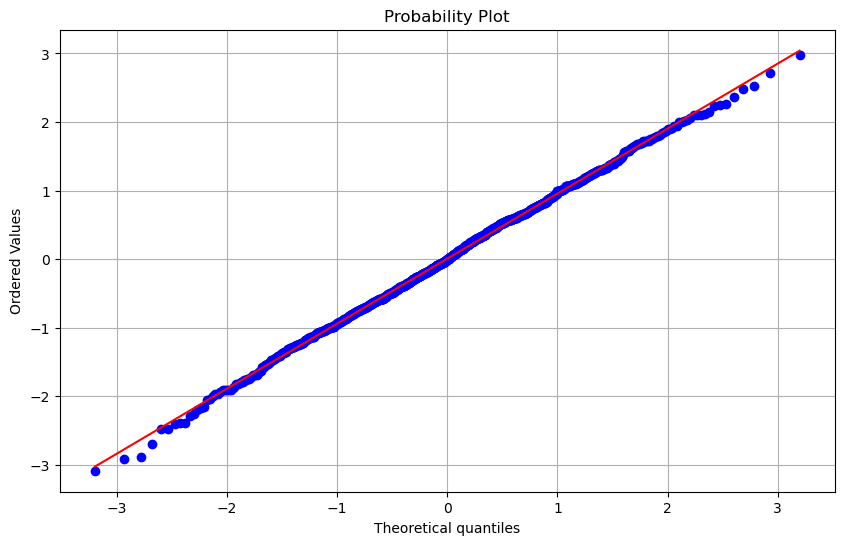

In [160]:
n = 1000
x = von_Neumann_Gauss_gen(n)
plt.figure(figsize=(10, 6))
plt.title('Normal probability plot')
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили выборки')
stats.probplot(x, plot=plt)
plt.grid()
plt.show()

Part 3.

In [162]:
n = 1000

In [164]:
%timeit Gauss_B_M_gen(n)

39.7 μs ± 1.22 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [166]:
%timeit von_Neumann_Gauss_gen(n)

36.4 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
n = 10000

In [170]:
%timeit Gauss_B_M_gen(n)

232 μs ± 2.38 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [172]:
%timeit von_Neumann_Gauss_gen(n)

357 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Задание 5.**
1. Пусть $X_i \sim N(\mu, σ^2)$. Убедиться эмпирически в справедливости теоремы о законе больших чисел (ЗБЧ) и центральной предельной теоремы (ЦПТ): исследовать поведение суммы $S_n =\sum\limits_{k=1}^n X_i$ и эмпирического распределения величины
$\sqrt{n}(\dfrac{S_n}{n} - \mu)$
2. Считая $\mu, \sigma$ неизвестными, построить доверительные интервалы для среднего и дисперсии по имеющейся выборке.
3. Пусть $X_i \sim K(a, b)$ — имеет распределение Коши с параметром сдвига $a$ и масштаба $b$. Изучить эмпирически как ведут себя суммы $\dfrac{S_n}{n}$, объяснить результат и найти закон распределения данных сумм.

Part 1.
ЗБЧ:
Пусть $X_1, X_2, \dots, X_n, \dots$ ~--~ последовательность независимых нормально распределенных случайных величин с параметрами $\mu$ и $\sigma^2,$ при этом $\mathbb{E}X_k^2 < \infty.$
Рассмотрим $S_n = \sum\limits_{k=1}{n}X_k.$ Справедливо следующее соотношение: $\forall \varepsilon > 0 \quad \mathbb{P}(\left| \dfrac{S_n}{n} - \mu \right| < \varepsilon) \rightarrow 1, n \rightarrow +\infty.$

ЦПТ:
Пусть $X_1, X_2, \dots, X_n, \dots$ ~--~ последовательность независимых нормально распределенных случайных величин с параметрами $\mu$ и $\sigma^2,$ причем математическое ожидание конечно, а дисперсия ненулевая. Тогда $\dfrac{S_n - \mu n}{\sigma \sqrt{n}} \rightarrow \mathcal{N}(0,1) (\text{ сходимость по распределению}), n\rightarrow +\infty.$

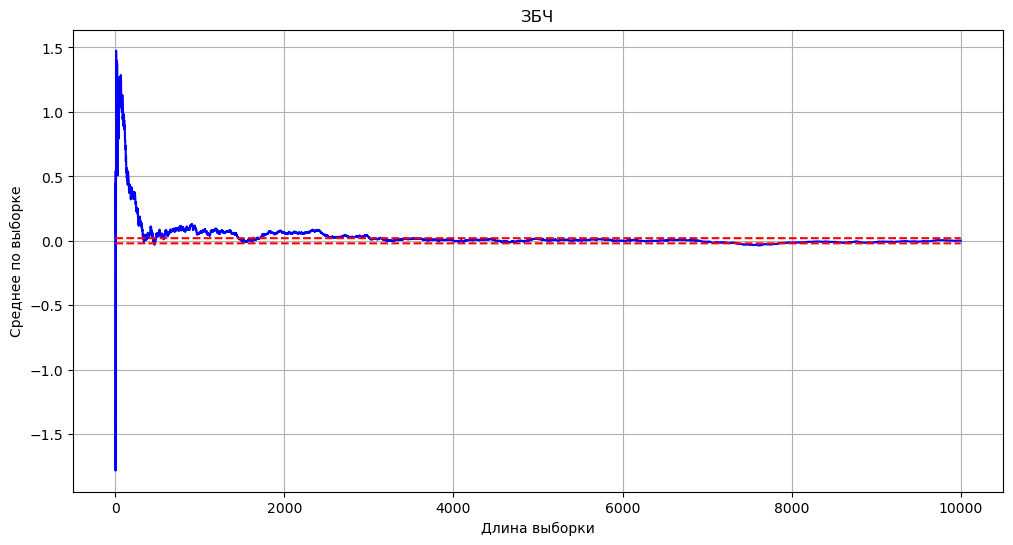

In [222]:
n = 10000
X = Gauss_B_M_gen(n)
mu = 0
sigma = 3
eps = 0.02
n_span = np.linspace(1, n + 1, n)
X = sigma * X + mu
S_n = np.cumsum(X) / n_span
plt.figure(figsize=(12, 6))
plt.plot(n_span, S_n, color='b')
plt.plot(n_span, np.ones(n_span.shape) * (mu + eps), '--r')
plt.plot(n_span, np.ones(n_span.shape) * (mu - eps), '--r')
plt.title('ЗБЧ')
plt.xlabel('Длина выборки')
plt.ylabel('Среднее по выборке')
plt.grid()
plt.show()

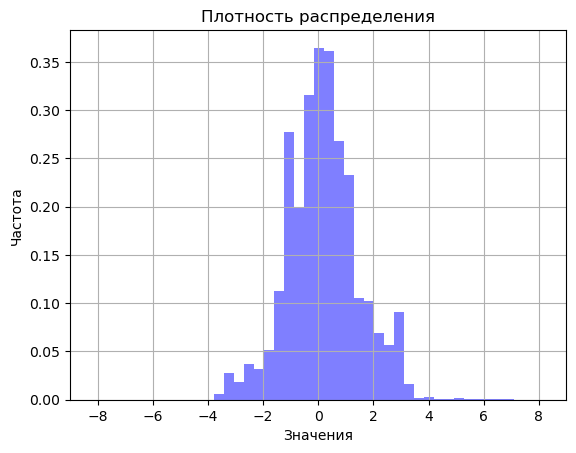

In [329]:
n = 10000
X = Gauss_B_M_gen(n)
mu = 0
sigma = 3
n_span = np.arange(1, n + 1)
X = sigma * X + mu
S_n = np.sqrt(n_span) * (np.cumsum(X) / n_span - mu)

plt.hist(S_n, bins=30, alpha=0.5, color='blue', density=True, label='Оригинальная выборка')
plt.title(f'Плотность распределения')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid()
plt.xlim([- 3 * sigma, 3 * sigma])
plt.show()





По ЗБЧ $S_n$ асимптотически ведет себя как $nX_1.$
$$\mathbb{E}S_n = n \mu,$$
$$\mathbb{D}S_n = n^2 \sigma^2.$$

По ЦПТ $\sqrt{n} (\dfrac{S_n}{n} - \mu)) \xrightarrow{d} \mathcal{N}(0, \sigma^2).$



Part 2.

Строим доверительный интервал для математического ожидания, используя t-критерий Стьюдента.
$$t = \sqrt{n}\dfrac{\overline{X} - \mu}{S}$$


Пусть $q(\alpha, n-1)$ ~---~ квантили порядка $\alpha$ распределения Стьюдента с $n-1$ степенями свободы.
Тогда доверительный интервал для среднего $\left[\overline{X} - q(1 - \dfrac{\alpha}{2}, n-1) \dfrac{S}{\sqrt{n}}, \overline{X} + q(1 - \dfrac{\alpha}{2}, n-1) \dfrac{S}{\sqrt{n}}\right]$, где $\alpha$ ~--~ заданный уровень значимости.


In [404]:
mu = 1
sigma = 1.5
alpha = 0.1
n = 1000
X = sigma * Gauss_B_M_gen(n) + mu

m = np.mean(X)
std = np.std(X)
t_critical = stats.t.ppf(1 - alpha / 2, df=n - 1)
mean_margin = t_critical * std / np.sqrt(n)
print(f'Доверительный интервал для среднего: [{m - mean_margin}, {m + mean_margin}]')

Доверительный интервал для среднего: [0.9416764157055133, 1.130155542248124]


Доверительный интервал для стандартного отклонения строится с помощью теоремы Фишера.

Пусть $X_1, X_2, \dots, X_n \sim \mathcal{N}(\mu, \sigma^2).$ Тогда статистика $H = \dfrac{(n-1)S^2}{\sigma^2}$ имеет распределение $\chi^2$ с $n-1$ степенью свободы.

Тогда верно следующее равенство:
$$\mathbb{P}\left(\chi^2_{n-1, \frac{\alpha}{2}} \leqslant \frac{(n-1)S^2}{\sigma^2} \leqslant \chi^2_{n-1, 1-\frac{\alpha}{2}}\right) = 1 - \alpha,$$
где $\chi^2_{n-1, \frac{\alpha}{2}}$ и $\chi^2_{n-1, 1-\frac{\alpha}{2}}$ ~---~ квантили $\chi^2$-распределения порядка $\dfrac{\alpha}{2}$ и $1 - \dfrac{\alpha}{2}$ соответственно.


Решая неравенство, находим $\sigma^2 \in \left[\dfrac{(n-1)S^2}{\chi^2_{n-1, 1-\frac{\alpha}{2}}}, \dfrac{(n-1)S^2}{\chi^2_{n-1, \frac{\alpha}{2}}}\right].$


In [421]:
mu = 1
sigma = 2
alpha = 0.05
n = 1000
X = sigma * np.random.randn(n_samples) + mu

var = np.var(X, ddof=1)
chi2_lower = stats.chi2.ppf(alpha / 2, df=n - 1)
chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=n - 1)
print(f'Доверительный интервал для дисперсии [{(n-1) * var / chi2_upper},{(n-1) * var / chi2_lower}], дисперсия распределения равна {sigma ** 2}')


Доверительный интервал для дисперсии [3.654083019751451,4.354995909115042], дисперсия распределения равна 4


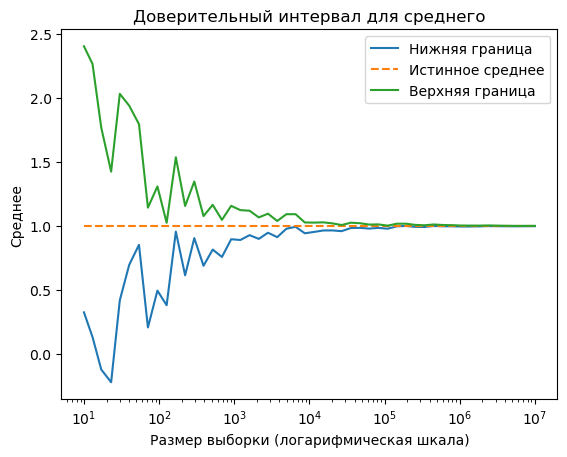

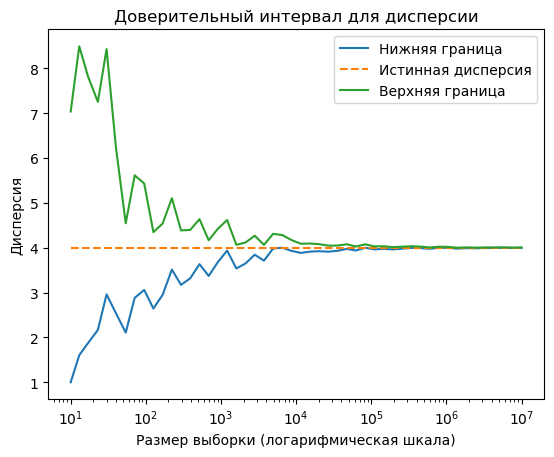

In [434]:
sample_sizes = np.logspace(1, 7, 50, dtype=int)
mean_intervals = []
variance_intervals = []

for size in sample_sizes:
    data = mu + sigma * np.random.randn(size)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    variance = np.var(data, ddof=1)

    t_critical = stats.t.ppf(1 - alpha / 2, df=size - 1)
    margin = t_critical * std_dev / np.sqrt(size)
    mean_intervals.append((mean - margin, mean + margin))

    chi2_lower = stats.chi2.ppf(alpha / 2, df=size - 1)
    chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=size - 1)
    lower_var = (size - 1) * variance / chi2_upper
    upper_var = (size - 1) * variance / chi2_lower
    variance_intervals.append((lower_var, upper_var))

mean_left = [i[0] for i in mean_intervals]
mean_right = [i[1] for i in mean_intervals]

plt.figure()
plt.plot(sample_sizes, mean_left, label='Нижняя граница')
plt.plot(sample_sizes, [mu] * len(sample_sizes), label='Истинное cреднее', linestyle='--')
plt.plot(sample_sizes, mean_right, label='Верхняя граница')
plt.xscale('log')
plt.xlabel('Размер выборки (логарифмическая шкала)')
plt.ylabel('Среднее')
plt.legend()
plt.title('Доверительный интервал для среднего')
plt.show()

var_left = [i[0] for i in variance_intervals]
var_right = [i[1] for i in variance_intervals]

plt.figure()
plt.plot(sample_sizes, var_left, label='Нижняя граница')
plt.plot(sample_sizes, [sigma**2] * len(sample_sizes), label='Истинная дисперсия', linestyle='--')
plt.plot(sample_sizes, var_right, label='Верхняя граница')
plt.xscale('log')
plt.xlabel('Размер выборки (логарифмическая шкала)')
plt.ylabel('Дисперсия')
plt.legend()
plt.title('Доверительный интервал для дисперсии')
plt.show()

Part 3.
$X_i \sim K(a, b), S_n = \sum\limits{i=1}{n} X_i.$ Характеристическая функция $\varphi_{X_i}(t) = e^{iat - b|t|}.$ Рассмотрим характеристическую функцию случайной величины $Y = \dfrac{S_n}{n}:$
$$\varphi_Y(t) = \mathbb{E}e^{itY} = \mathbb{E}e^{\frac{it}{n}\sum\limits_{i=1}^n X_i} = (\mathbb{E}e^{\frac{it}{n}X_1})^n = \varphi_{X_i}(t).$$

Следовательно, $Y \sim K(a, b).$


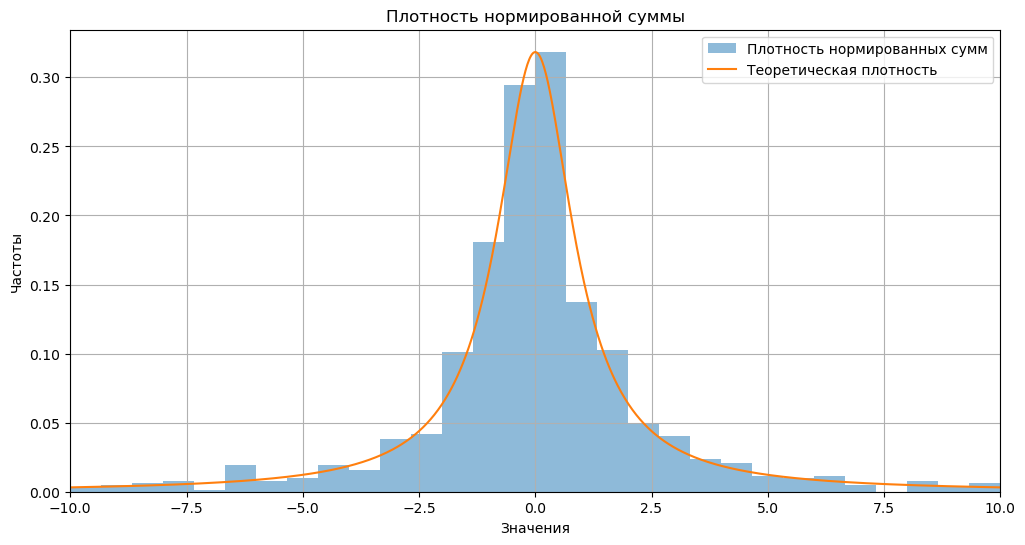

In [461]:
n = 1000
length = 1000
x_0 = 0
gamma = 1

X = Cauchy_gen(x_0, gamma, (n, length)).sum(axis=0) / n
dens_th = lambda x: 1 / (math.pi * gamma * (1 + ((x - x_0) / gamma)**2))

plt.figure(figsize=(12, 6))
plt.title('Плотность нормированной суммы')
plt.xlabel('Значения')
plt.ylabel('Частоты')
plt.hist(X, bins=30, alpha=0.5, range=(-10, 10), density=True, label='Плотность нормированных сумм')
plt.plot(x := np.linspace(-10, 10, n), dens_th(x), label="Теоретическая плотность")
plt.grid()
plt.legend()
plt.xlim(-10, 10)
plt.show()

**Задание 6.**
1. Вычислить следующий интеграл:
$$\int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} \dots \int\limits_{-\infty}^{\infty} \dfrac{\exp\{x_1^2 + x_2^2 + \dots + x_{10}^2 + \frac{1}{2^7x_1^2x_2^2\dots x_{10}^2}\}}{x_1^2x_2^2\dots x_{10}^2} dx_1dx_2\dots dx_{10}$$
  1. Методом Монте-Карло
  2. Методом квадратур, сводя задачу к вычислению собственного интеграла
Римана.
2. Оценить точность вычислений для каждого из двух случаев.


Part 1.
Рассмотрим $X_1, X_2, \dots, X_{10} \sim \mathcal{N}(0, \dfrac{1}{\sqrt{2}})$ ~--~ независимые случайные величины. Плотность каждой $f(x) = \dfrac{1}{\sqrt{\pi}} e^{-x^2}.$ Пусть $y = \left(\prod\limits_{i=1}{10} x_i\right)^{-2}.$ Тогда подынтегральная функция равна $\pi^5ye^{-\dfrac{y}{2^7}}f(x).$ Тогда весь интеграл равен математическому ожиданию $\mathbb{E}g(Y),$ где $g(y) = \pi^5ye^{-\dfrac{y}{2^7}}, Y = \left(\prod\limits_{i=1}{10} X_i\right)^{-2}.$

Тогда по усиленному закону больших чисел $\dfrac{S_n}{n} = \dfrac{\sum\limits_{i_j=1}^{10}x_{i_j}}{n} \xrightarrow[n\rightarrow +\infty]{} \mathbb{E}g(Y).$

In [756]:
def monte_carlo_approach(iter_num):
    g = lambda y: np.pi ** 5 * y * np.exp(-y / 128)
    samples = (np.random.randn(10, iter_num) / np.sqrt(2)).prod(0) ** (-2)
    return g(samples).mean()

In [758]:
iter_num = 100000
print(monte_carlo_approach(iter_num))

125.60480142864812


Метод квадратур.

Заметим, что подынтегральная функция четная и можно рассматривать интегралы от 0 до $+\infty.$
Сделаем замены: $x_i = \tan(\dfrac{\pi}{2}y_i), y_i \in (0, 1).$ После замены получим
$$I = \pi^{10}\int\limits_0^1\int\limits_0^1\dots\int\limits_0^1 \dfrac{exp\{\sum\limits_{k=1}^{10}\tan^2(\dfrac{\pi}{2}y_k + \dfrac{1}{128}\prod\limits_{k=1}^{10}\dfrac{1}{\tan^2(\dfrac{\pi}{2}y_k)})\}}{\prod\limits_{k=1}^{10}\sin^2(\dfrac{\pi}{2}y_k)}dy_1dy_2\dots dy_{10}.$$
Такой интеграл можно посчитать методом квадратур, т.е. приблизить его суммой площадей элементарных фигур.
Формула для метода прямоугольников со значением в середине отрезка разбиения:
$I \approx (\dfrac{\pi}{N})^10 \sum\limits_{1\leq i_1 \leq i_2 \leq \dots \leq i_{10} \leq N}С^{m}_{m_1, \ldots, m_l} f(x_1^{2i_1 - 1}, x_2^{2i_2 - 1}, \dots, x_{10}^{2i_{10} - 1}),$ где $С^{m}_{m_1, \ldots, m_l} = \frac{10!}{m_1!m_2!\cdots m_{l}!},$
$m_k$ - количество индексов в наборе $(i_1,i_2,\dots,i_{10})$, равных $k$.

In [798]:
def int_func(t):
    denominator = (np.sin(np.pi / 2 * t) ** 2).prod()
    degree = -np.sum(np.tan(np.pi / 2 * t)**2) - 1 / 128 * np.prod(1 / np.tan(np.pi / 2 * t)**2)
    return np.exp(degree) / denominator

In [800]:
def constants(sum_ind):
    val, counts = np.unique(sum_ind, return_counts=True)
    denominator = 1
    for i in range(len(counts)):
        denominator = denominator * math.factorial(counts[i])
    return math.factorial(10) / denominator    

In [802]:
from itertools import combinations_with_replacement
def quadr_approach(N):
    integral = 0
    grid = np.linspace(0.5 / (N + 1), 1 - 0.5/(N + 1), N, )
    C_i = combinations_with_replacement(np.arange(0, N), 10)#всевозможные индексы
    for sum_ind in C_i:
        variables = grid[list(sum_ind)]
        const = constants(sum_ind)
        integral += const * int_func(variables)
    return (math.pi / N) ** 10 * integral

In [808]:
N = 10
quadr_approach(N)

112.44919128608934